# Flower Image Classification

# Setup

In [3]:
import os
import random
import numpy as np  
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# Load Images For Training

In [4]:
IMAGE_SIZE = (224, 224)

In [5]:
train_raw, val_raw = tf.keras.utils.image_dataset_from_directory(
    directory="../input/flowers-dataset/train",
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=IMAGE_SIZE,
    batch_size=64)

rescale = keras.layers.Rescaling(1./255)

train_ds = train_raw.map(lambda x, y: (rescale(x), y), tf.data.AUTOTUNE)
val_ds = val_raw.map(lambda x, y: (rescale(x), y), tf.data.AUTOTUNE)

Found 2746 files belonging to 5 classes.
Using 2197 files for training.
Using 549 files for validation.


# Create Model

In [9]:
def entry_block(prev_layer, state, filters, lk_size):
    dw = keras.layers.DepthwiseConv2D(
            kernel_size=(3, 3),
            padding='same'
        )(prev_layer)
    dw_d = keras.layers.DepthwiseConv2D(
            kernel_size=lk_size,
            padding='same',
            dilation_rate=3
        )(dw)
    pw = keras.layers.Conv2D(
        filters,
        kernel_size=(1, 1)
    )(dw_d)
    lk_bn = keras.layers.BatchNormalization()(pw)
    conv2d = keras.layers.Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(prev_layer)
    bn = keras.layers.BatchNormalization()(conv2d)
    max_pool = keras.layers.MaxPooling2D()(bn)
    relu = tf.nn.relu(lk_bn)
    out_conv = keras.layers.Conv2D(
        filters,
        kernel_size=(1, 1),
        padding='same',
        use_bias=False
    )(relu)
    out_bn = keras.layers.BatchNormalization()(out_conv)
    lk_max_pool = keras.layers.MaxPooling2D()(out_bn)
    state_conv = keras.layers.Conv2D(
        filters*2, 
        kernel_size=(1, 1), 
        strides=(1, 1), 
        padding='same',
        use_bias=False)(state)
    state_bn = keras.layers.BatchNormalization()(state_conv)
    state_max_pool = keras.layers.MaxPooling2D()(state_bn)
    concat = keras.layers.Concatenate(axis=-1)([lk_max_pool, max_pool])
    add = keras.layers.Add()([concat, state_max_pool])
    return add, state_max_pool


In [10]:
def conv_block(prev_layer, state, filters):
    conv_1 = keras.layers.DepthwiseConv2D(kernel_size=(3, 3), strides=(1, 1), padding='same')(prev_layer)
    bn_1 = keras.layers.BatchNormalization()(conv_1)
    bn_1 = tf.nn.relu(bn_1)
    conv_2 = keras.layers.Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(bn_1)
    bn_2 = keras.layers.BatchNormalization()(conv_2)
    max_pool = keras.layers.MaxPooling2D()(bn_2)

    sep_conv = keras.layers.SeparableConv2D(filters, kernel_size=(3, 3), strides=(2, 2), padding='same')(prev_layer)
    sep_bn = keras.layers.BatchNormalization()(sep_conv)
    
    add = keras.layers.Add()([max_pool, sep_bn])
    state = tf.nn.relu(state)
    state_conv = keras.layers.Conv2D(
        filters, 
        kernel_size=(1, 1), 
        strides=(1, 1), 
        padding='same',
        use_bias=False)(state)
    state_bn = keras.layers.BatchNormalization()(state_conv)
    state_max_pool = keras.layers.MaxPooling2D()(state_bn)
    
    concat = keras.layers.Concatenate()([add, state_max_pool])
    return tf.nn.relu(concat)

In [11]:
def exit_block(prev_layer, filters):
    conv_1 = keras.layers.Conv2D(filters, kernel_size=(1, 1), strides=(1, 1), padding='valid')(prev_layer)
    bn_1 = keras.layers.BatchNormalization()(conv_1)

    conv_2 = keras.layers.DepthwiseConv2D(kernel_size=(3, 3), strides=(1, 1), padding='same')(prev_layer)
    bn_2 = keras.layers.BatchNormalization()(conv_2)
  
    concat = keras.layers.Concatenate(axis=-1)([bn_1, bn_2])
    
    return tf.nn.relu(concat)
    

In [12]:
def make_model(num_classes):
    inp = keras.Input(shape=(224, 224, 3))
    zero_padding = keras.layers.ZeroPadding2D(padding=(3, 3))(inp)
    conv2d = keras.layers.Conv2D(64, kernel_size=(7, 7), strides=(1, 1), bias_initializer='glorot_uniform')(zero_padding)
    bn = keras.layers.BatchNormalization()(conv2d)
    relu_1 = tf.nn.relu(bn)
    max_pooling = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(relu_1) # 112, 112, 64
    entry_1, state = entry_block(max_pooling, max_pooling, 64, (7, 7))
    entry_1 = tf.nn.relu(entry_1)
    entry_2, state = entry_block(entry_1, state, 128, (7, 7))
    entry_2 = tf.nn.relu(entry_2)
    entry_3, state = entry_block(entry_2, state, 256, (5, 5))
    entry_3 = tf.nn.relu(entry_3)
    conv = conv_block(entry_3, state, 512)
    ex = exit_block(conv, 1024)
    avg_pool = keras.layers.GlobalAveragePooling2D()(ex)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
    logits = keras.layers.Dense(units, activation=activation)(avg_pool)
    return keras.Model(inp, logits)

In [13]:
model = make_model(num_classes=5)

In [14]:
opt = keras.optimizers.Adam(learning_rate=1e-3)

model.compile(optimizer=opt,
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=[
                  keras.metrics.SparseCategoricalAccuracy()
                  ])

# Summary

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

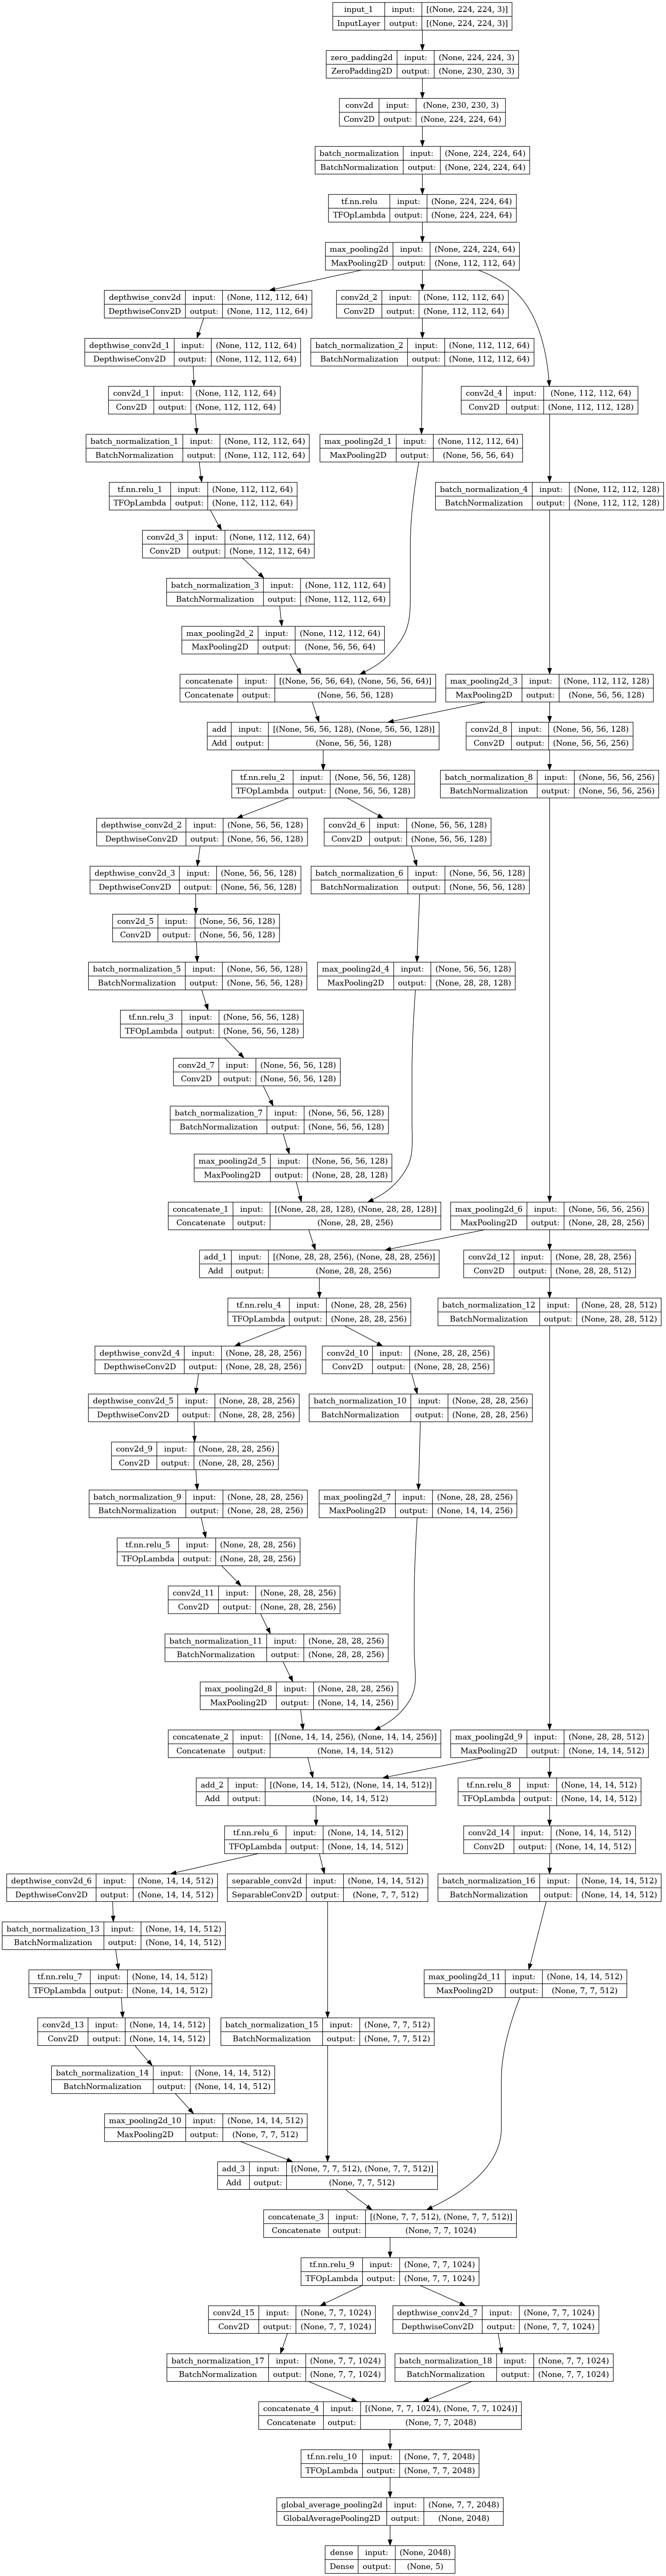

In [16]:
keras.utils.plot_model(model, show_shapes=True)

# Training model

In [17]:
checkpoint = keras.callbacks.ModelCheckpoint(
    "./model_checkpoint.ckpt",
    monitor="val_sparse_categorical_accuracy",
    verbose=1,
    save_best_only=True,
    mode="max"
)

In [18]:
history = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[checkpoint])

Epoch 1/50
35/35 [==============================] - ETA: 0s - loss: 1.1488 - sparse_categorical_accuracy: 0.5826
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.24954, saving model to ./model_checkpoint.ckpt
35/35 [==============================] - 83s 1s/step - loss: 1.1488 - sparse_categorical_accuracy: 0.5826 - val_loss: 1.8088 - val_sparse_categorical_accuracy: 0.2495
Epoch 2/50
35/35 [==============================] - ETA: 0s - loss: 0.8326 - sparse_categorical_accuracy: 0.6868
Epoch 2: val_sparse_categorical_accuracy did not improve from 0.24954
35/35 [==============================] - 29s 797ms/step - loss: 0.8326 - sparse_categorical_accuracy: 0.6868 - val_loss: 2.1377 - val_sparse_categorical_accuracy: 0.2495
Epoch 3/50
35/35 [==============================] - ETA: 0s - loss: 0.6995 - sparse_categorical_accuracy: 0.7319
Epoch 3: val_sparse_categorical_accuracy did not improve from 0.24954
35/35 [==============================] - 29s 790ms/step - loss: 0.6995 -

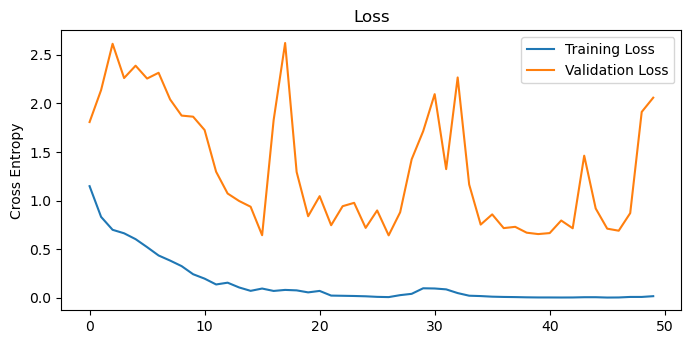

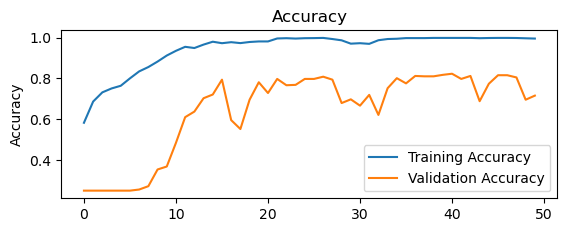

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(8, 8))

# plot losses
plt.subplot(2, 1, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Loss')
plt.show()

# plot accs
plt.subplot(2, 1, 2)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.show()

# Restore model at best val_loss

In [20]:
model.load_weights("./model_checkpoint.ckpt")

In [22]:
model.evaluate(val_ds, return_dict=True)

9/9 [==============================] - 2s 213ms/step - loss: 0.6658 - sparse_categorical_accuracy: 0.8233


{'loss': 0.6657516360282898, 'sparse_categorical_accuracy': 0.8233151435852051}

# Evaluation

In [23]:
test_images = list(os.listdir("../input/flowers-dataset/test"))

In [24]:
classes = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [25]:
def visualize_predicted_probabilities(model, image_path):
    img = keras.utils.load_img(
        image_path, target_size=(224, 224)
    )
    img_array = keras.utils.img_to_array(img)/255.0
    fig = plt.figure(figsize=(10, 5))
    gs = fig.add_gridspec(ncols=2, hspace=0.0, wspace=0.5)
    axes = gs.subplots()
    axes[0].imshow(img_array)
    axes[0].set_xticks([])
    axes[0].set_yticks([])

    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    predictions = model.predict(img_array, verbose=0)[0]
    print(f'''Probability of belonging to classes: 
            {100 * predictions[0]:.2f}% daisy
            {100 * predictions[1]:.2f}% dandelion
            {100 * predictions[2]:.2f}% rose
            {100 * predictions[3]:.2f}% sunflower
            {100 * predictions[4]:.2f}% tulip''')
    index = np.arange(len(classes))
    axes[1].bar(index, predictions)
    axes[1].set_xlabel('Labels', fontsize=10)
    axes[1].set_ylabel('Probability', fontsize=10)
    axes[1].set_xticks(index, classes, fontsize=10, rotation=20)
    axes[1].set_title('Probability for test image')
    
    plt.show()


In [26]:
random_indices = np.random.choice(len(test_images), size=20)


**************************************************************************************************************************
Probability of belonging to classes: 
            0.46% daisy
            99.31% dandelion
            0.21% rose
            0.02% sunflower
            0.01% tulip


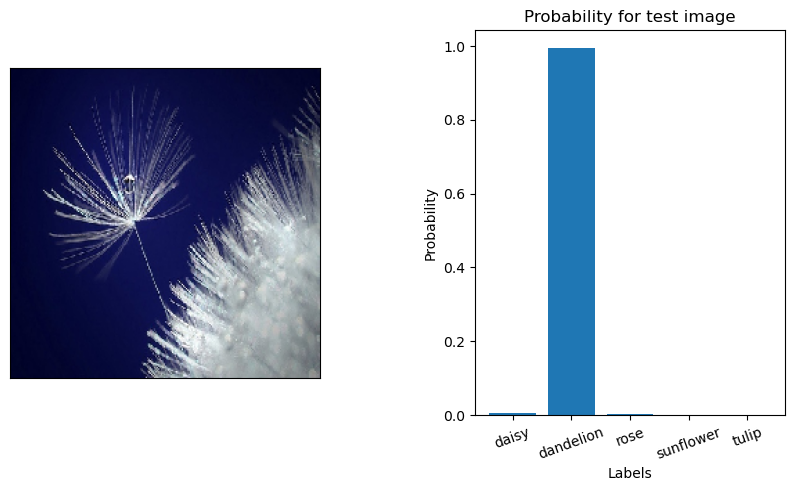


**************************************************************************************************************************
Probability of belonging to classes: 
            0.00% daisy
            100.00% dandelion
            0.00% rose
            0.00% sunflower
            0.00% tulip


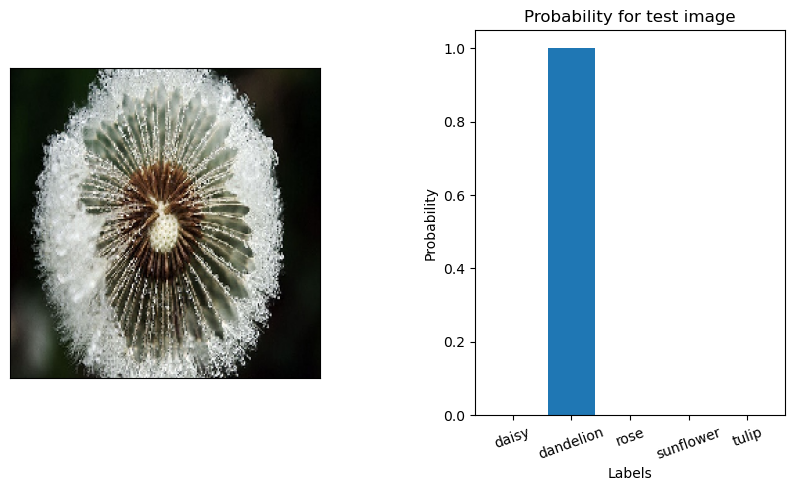


**************************************************************************************************************************
Probability of belonging to classes: 
            0.00% daisy
            0.00% dandelion
            0.00% rose
            0.00% sunflower
            100.00% tulip


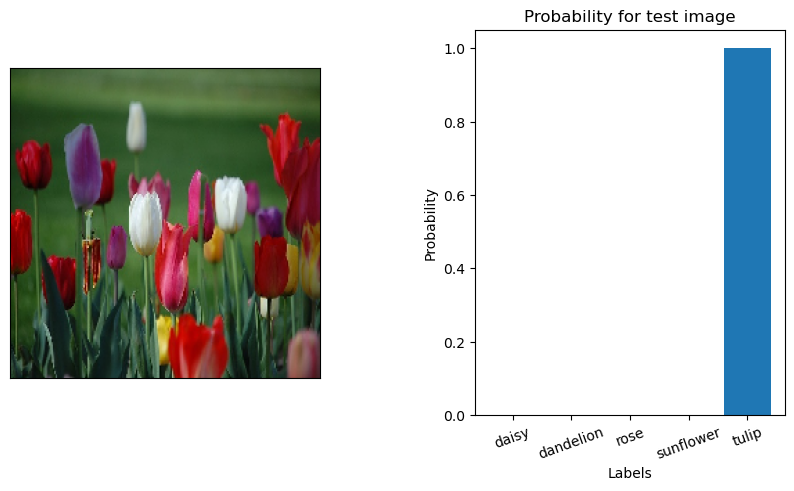


**************************************************************************************************************************
Probability of belonging to classes: 
            0.01% daisy
            0.34% dandelion
            0.02% rose
            99.59% sunflower
            0.03% tulip


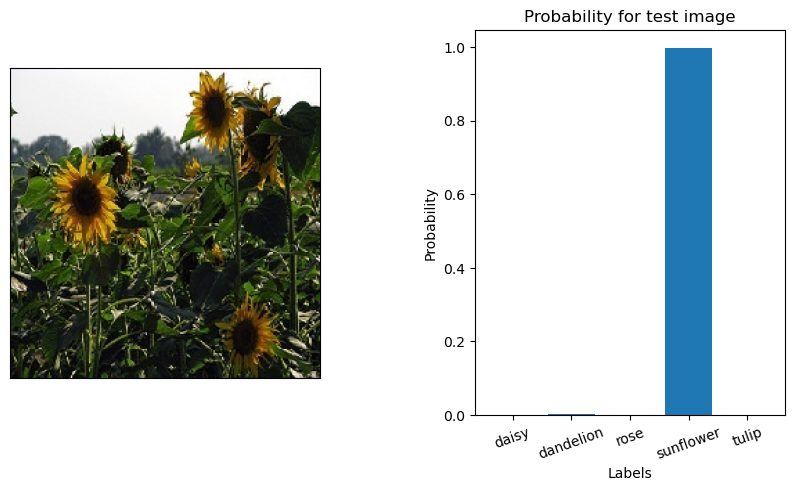


**************************************************************************************************************************
Probability of belonging to classes: 
            0.03% daisy
            99.93% dandelion
            0.03% rose
            0.00% sunflower
            0.00% tulip


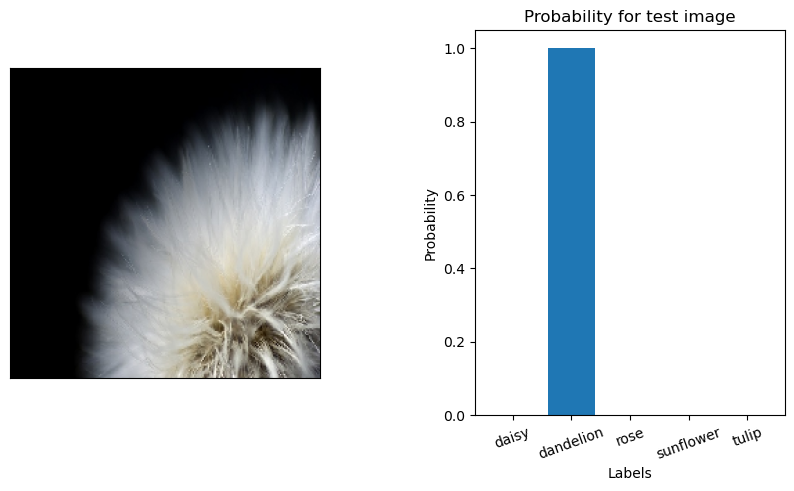


**************************************************************************************************************************
Probability of belonging to classes: 
            0.07% daisy
            30.86% dandelion
            1.09% rose
            0.04% sunflower
            67.95% tulip


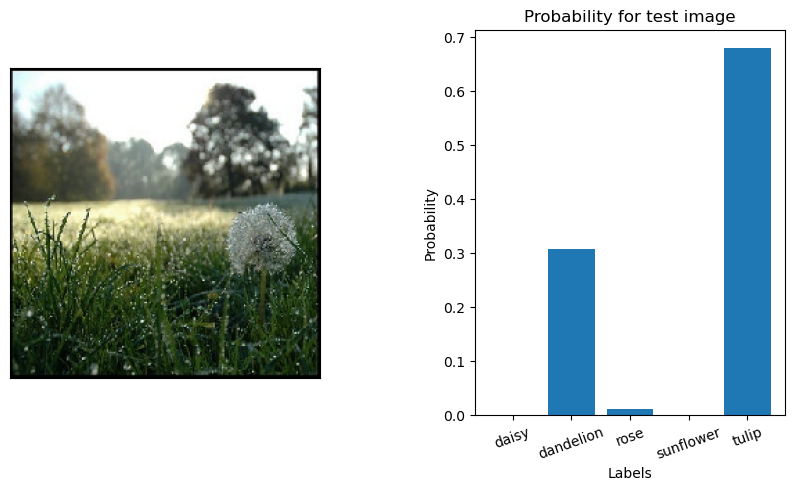


**************************************************************************************************************************
Probability of belonging to classes: 
            0.00% daisy
            0.00% dandelion
            0.01% rose
            0.02% sunflower
            99.97% tulip


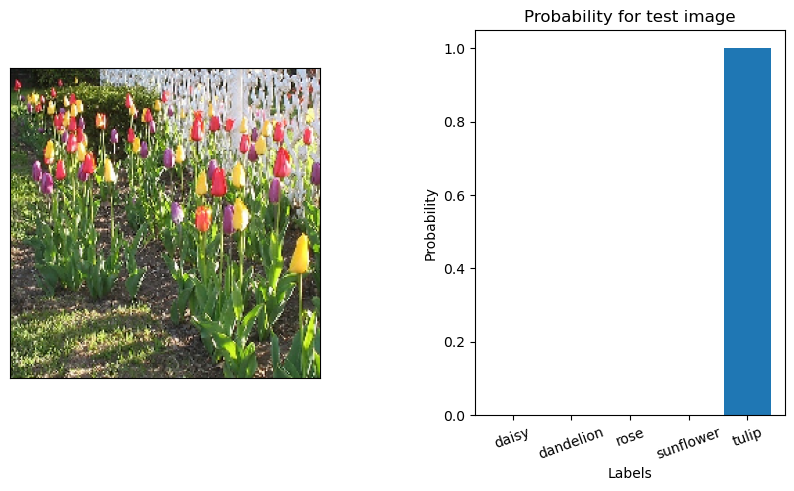


**************************************************************************************************************************
Probability of belonging to classes: 
            0.01% daisy
            99.90% dandelion
            0.00% rose
            0.00% sunflower
            0.09% tulip


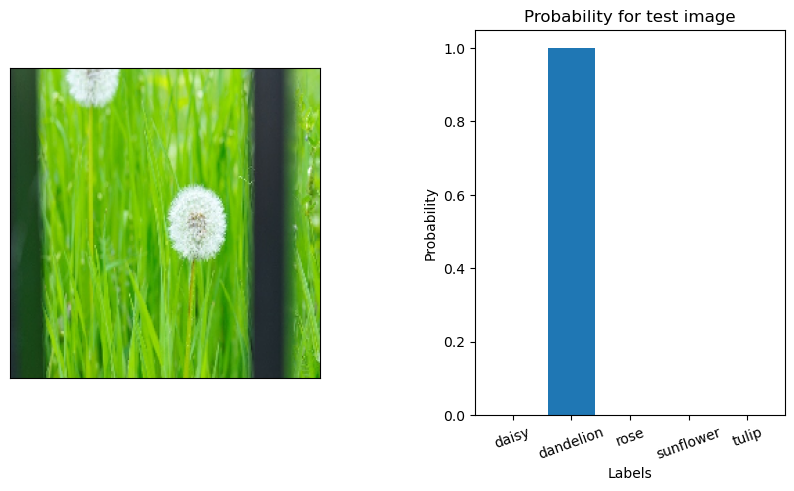


**************************************************************************************************************************
Probability of belonging to classes: 
            0.00% daisy
            0.00% dandelion
            100.00% rose
            0.00% sunflower
            0.00% tulip


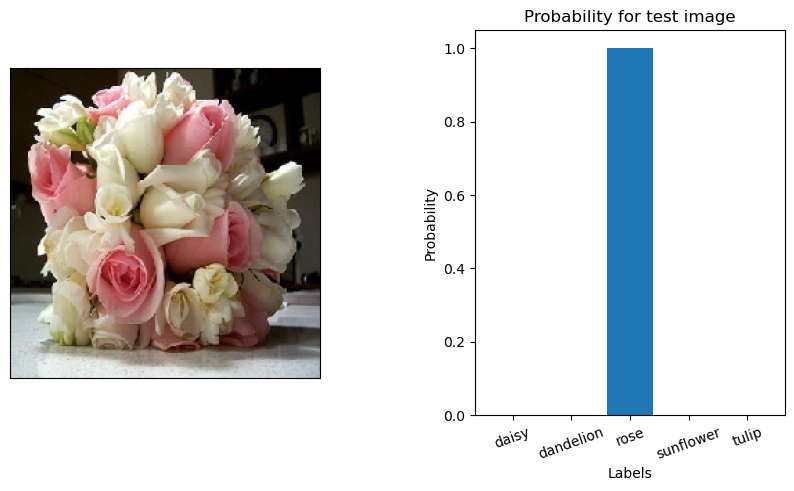


**************************************************************************************************************************
Probability of belonging to classes: 
            99.99% daisy
            0.00% dandelion
            0.00% rose
            0.00% sunflower
            0.01% tulip


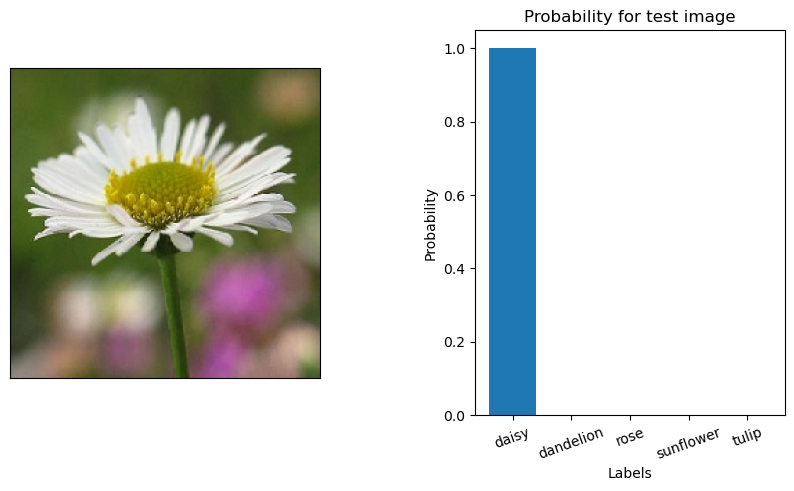


**************************************************************************************************************************
Probability of belonging to classes: 
            0.00% daisy
            0.00% dandelion
            99.86% rose
            0.00% sunflower
            0.14% tulip


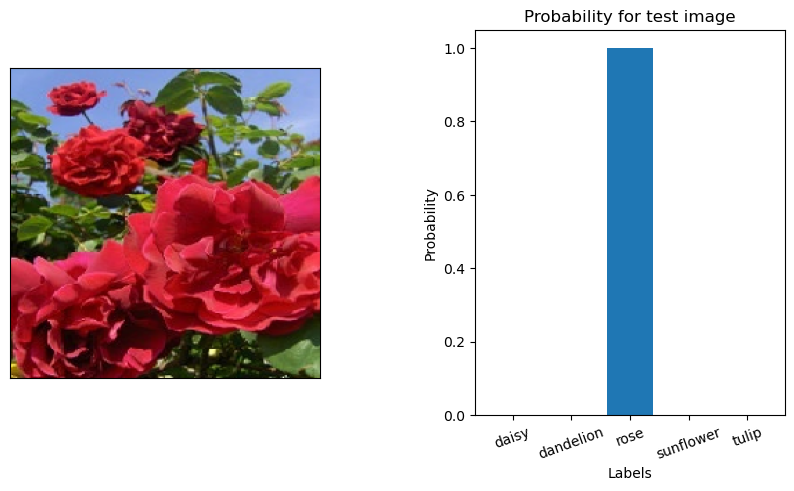


**************************************************************************************************************************
Probability of belonging to classes: 
            0.00% daisy
            99.34% dandelion
            0.00% rose
            0.00% sunflower
            0.65% tulip


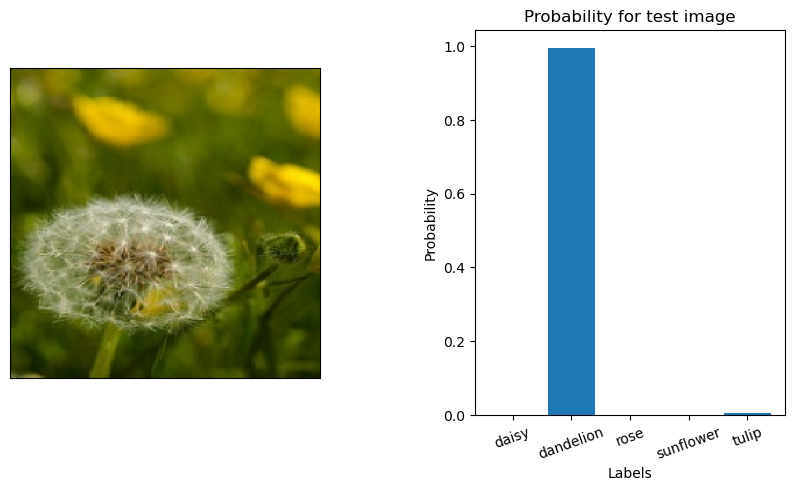


**************************************************************************************************************************
Probability of belonging to classes: 
            96.34% daisy
            0.02% dandelion
            0.61% rose
            3.03% sunflower
            0.00% tulip


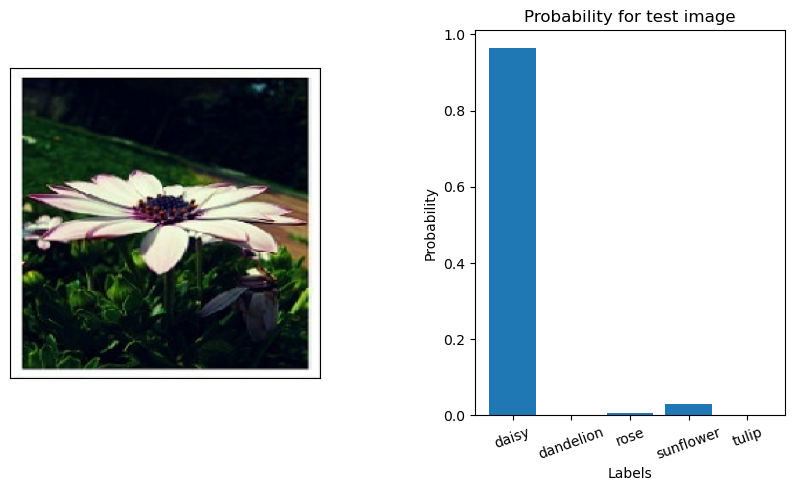


**************************************************************************************************************************
Probability of belonging to classes: 
            0.18% daisy
            99.61% dandelion
            0.14% rose
            0.01% sunflower
            0.06% tulip


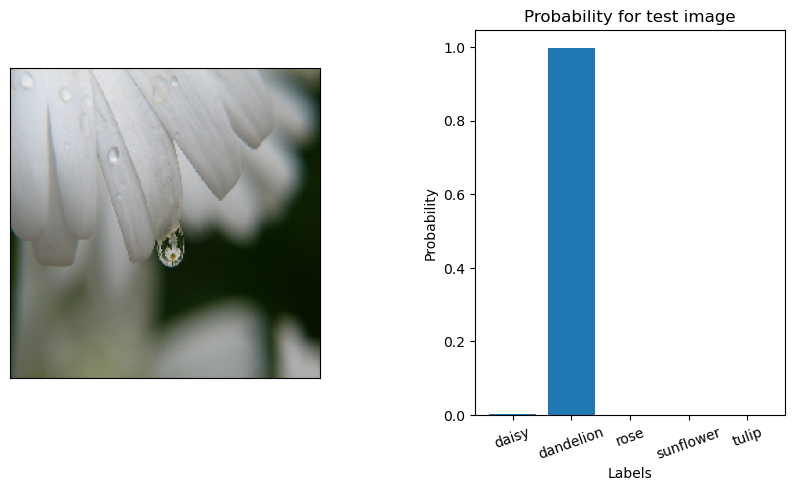


**************************************************************************************************************************
Probability of belonging to classes: 
            0.00% daisy
            0.00% dandelion
            0.00% rose
            100.00% sunflower
            0.00% tulip


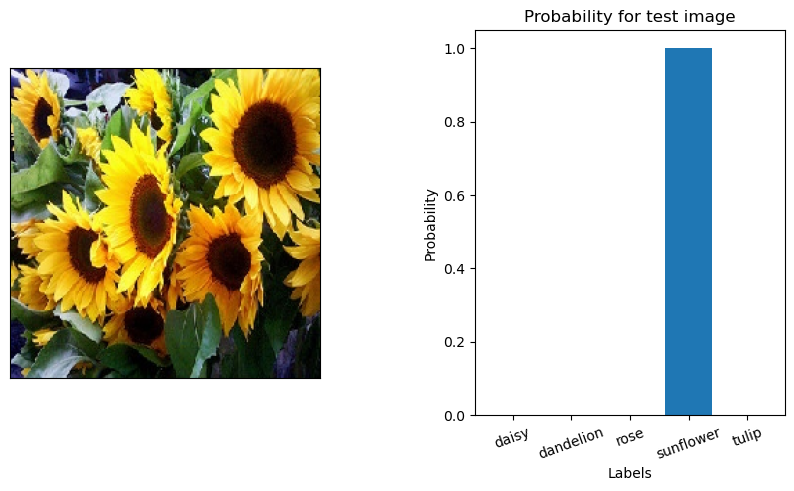


**************************************************************************************************************************
Probability of belonging to classes: 
            4.74% daisy
            54.95% dandelion
            19.82% rose
            0.06% sunflower
            20.43% tulip


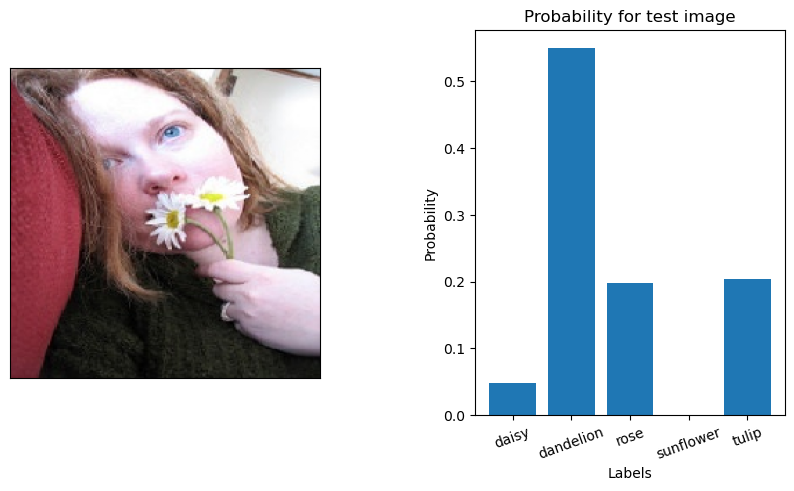


**************************************************************************************************************************
Probability of belonging to classes: 
            21.85% daisy
            0.06% dandelion
            5.30% rose
            72.53% sunflower
            0.26% tulip


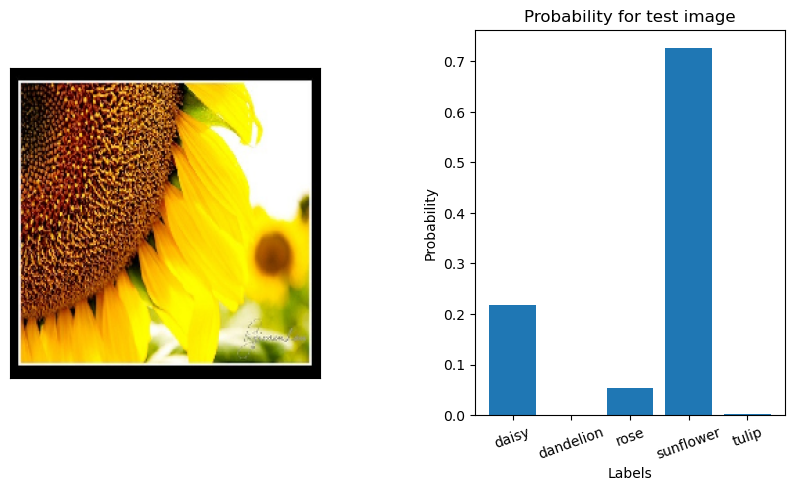


**************************************************************************************************************************
Probability of belonging to classes: 
            0.00% daisy
            0.00% dandelion
            0.00% rose
            0.00% sunflower
            100.00% tulip


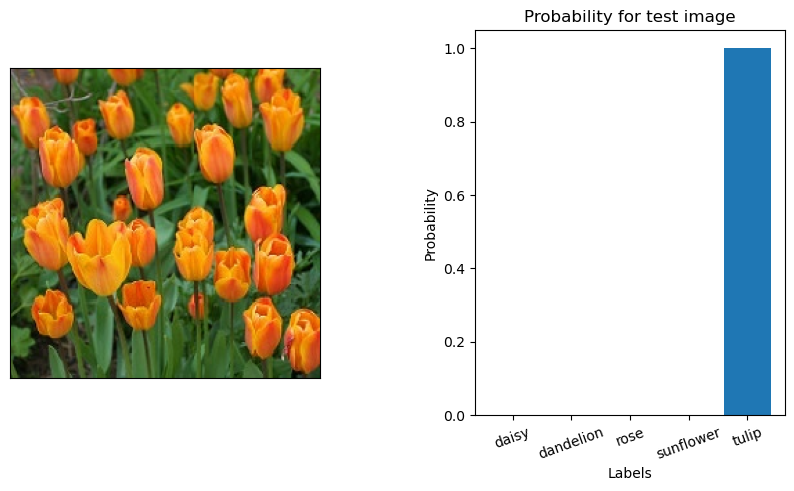


**************************************************************************************************************************
Probability of belonging to classes: 
            0.00% daisy
            0.00% dandelion
            0.00% rose
            99.99% sunflower
            0.01% tulip


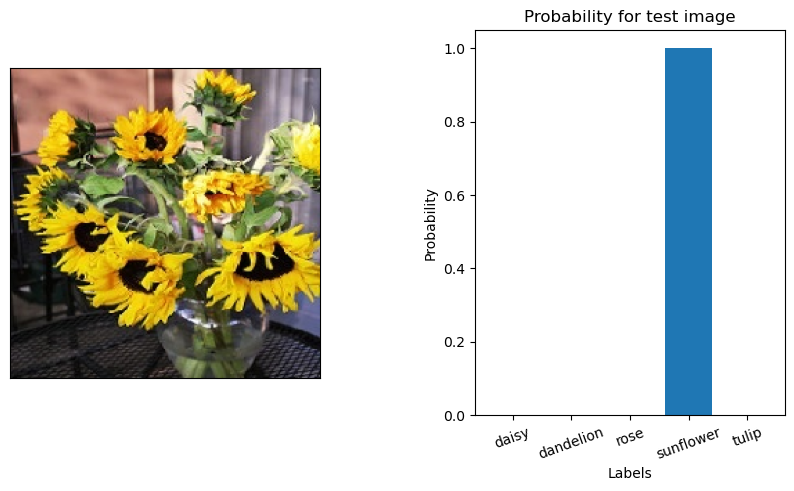


**************************************************************************************************************************
Probability of belonging to classes: 
            0.00% daisy
            0.00% dandelion
            0.00% rose
            100.00% sunflower
            0.00% tulip


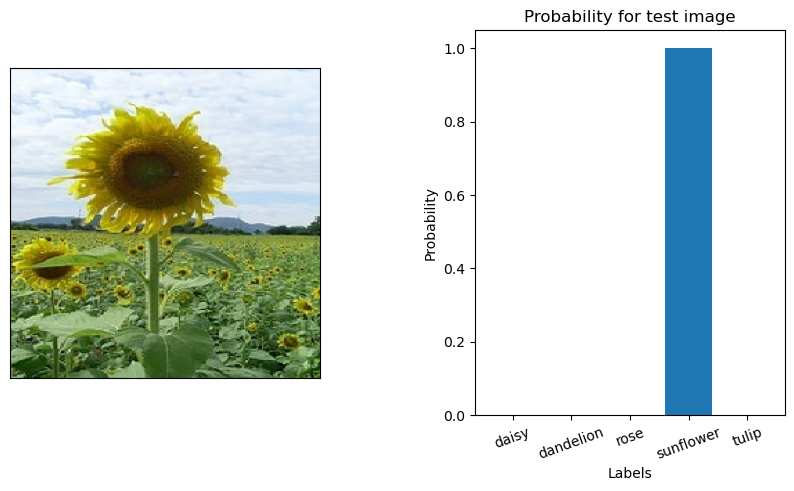

In [27]:
for i in random_indices:
    print('\n**************************************************************************************************************************')
    visualize_predicted_probabilities(model, "/kaggle/input/flowers-dataset/test/" + test_images[i])

In [28]:
model.save('flower_model.h5')